## Vehicle Detection Project

The goals / steps of this project are the following:

* Manual Vehicle Detection.
* Template Matching.
* Explore Color Spaces.
* Spatial Binning of Color.
* HOG Feature.
* Sliding Window Implementation.
* Hog Sub-sampling Window Search.

## Import Packages

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import os
import glob
import math
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn import svm, datasets,grid_search
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import warnings
warnings.filterwarnings("ignore")
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Show Images Function

In [4]:
def show_images(images,lable = None,cols = 3,cmap = None,ticksshow = False):
    
    rows = (len(images)+cols-1)//cols 
    
    plt.figure(figsize=(14, 14))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        # use gray scale color map if there is only one channel   
        showimage_shape = image.shape

        if len(showimage_shape) == 2: 
            cmap = "gray"
        elif  showimage_shape[2] == 1:
            image = image[:,:,0]
            cmap = "gray"
        
        plt.imshow(image, cmap=cmap)
        if lable != None and lable[i] != None:
            plt.title(lable[i],fontsize=14)
            
        if ticksshow != True:
            plt.xticks([])
            plt.yticks([])
            
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## Manual Vehicle Detection

A lot of bouding boxes on vehicle position in image will be drawn by human.

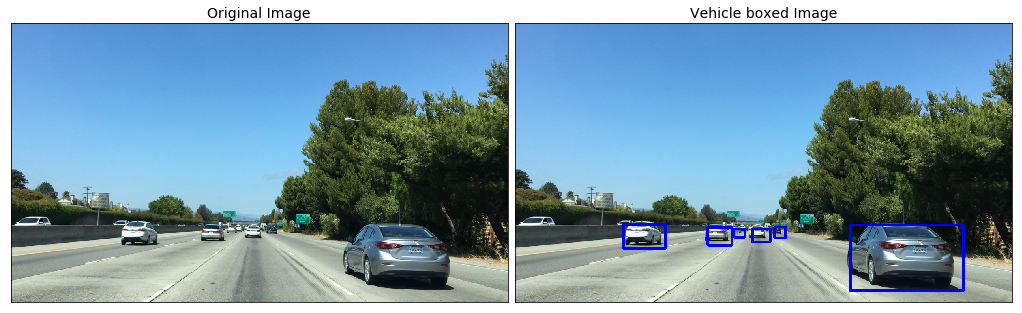

In [5]:
image = mpimg.imread('resources/bbox-example-image.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

result = draw_boxes(image, bboxes)

show_images([image,result],['Original Image','Vehicle boxed Image'],cols = 2)

## Template Matching

Template Matching takes in an image and a list of templates, and returns a list of the best fit location (bounding box) for each of the templates within the image. OpenCV provides you with the handy function `cv2.matchTemplate()` to search the image, and `cv2.minMaxLoc()` to extract the location of the best match.

The "squared difference" or "correlation" methods can be in used by `cv2.matchTemplate()`.

### Template show

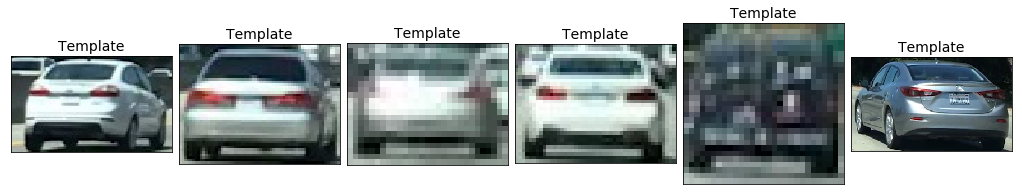

In [6]:
image = mpimg.imread('resources/bbox-example-image.jpg')

templist = ['cutout1.jpg', 'cutout2.jpg', 'cutout3.jpg',
            'cutout4.jpg', 'cutout5.jpg', 'cutout6.jpg']    
    
def templistread(template_list,index = 'resources/'):
    tmp = []
    for temp in template_list:
        # Read in templates one by one
        img = mpimg.imread(index + temp)
        tmp.append(img)
        
    return tmp

show_images(templistread(templist),len(templist)*['Template'],cols = len(templist))

### Template matched show

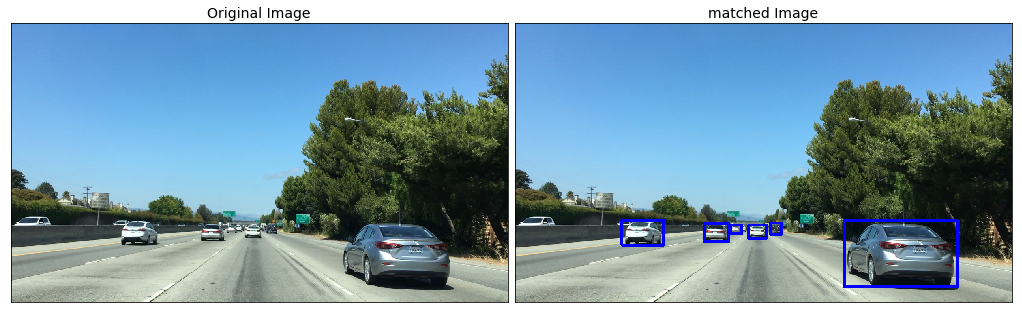

In [7]:
# Define a function to search for template matches
# and return a list of bounding boxes
def find_matches(img, template_list,index = 'resources/'):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(index + temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list


bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)

show_images([image,result],['Original Image','matched Image'],cols = 2)

## Histograms of Color

Histograms of Color using raw pixel intensities as features and histograms of pixel intensity (color histograms) as features.

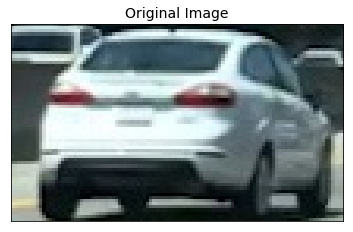

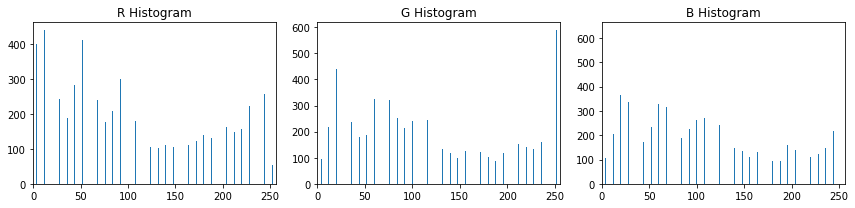

In [8]:
image = mpimg.imread('resources/cutout1.jpg')

show_images([image],['Original Image'])

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    ghist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    bhist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0],ghist[0],bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Function is returning None for at least one variable...')

## Explore Color Spaces

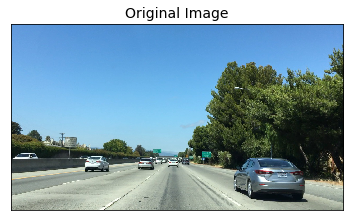

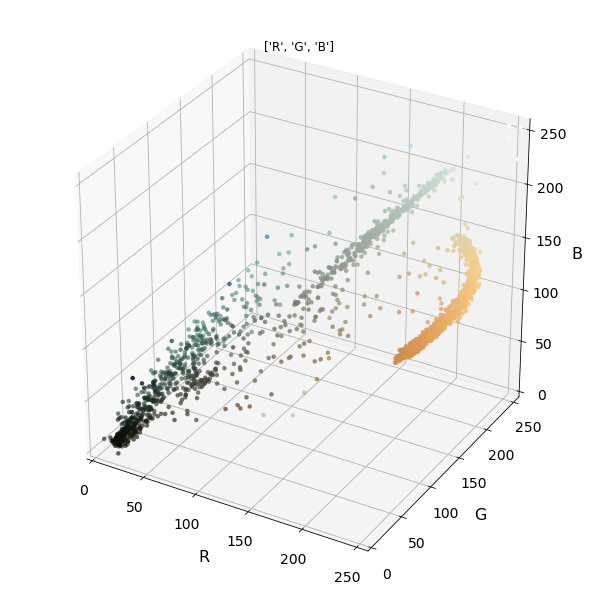

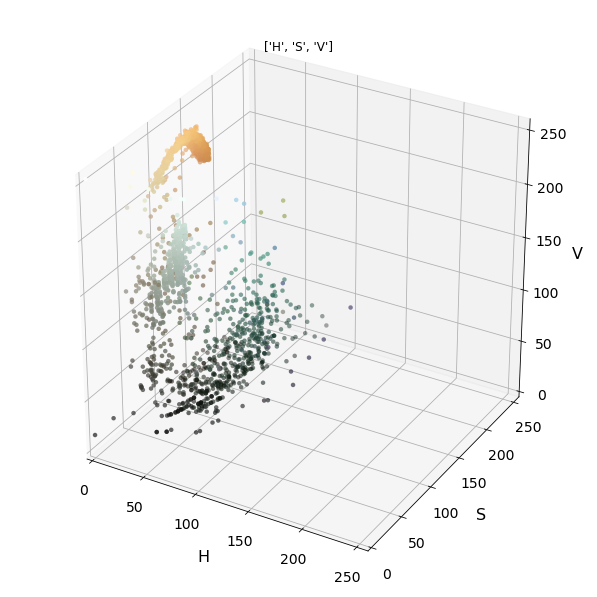

In [9]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_title(axis_labels)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = mpimg.imread('resources/bbox-example-image.jpg')
show_images([img],['Original Image'])

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

## Spatial Binning of Color

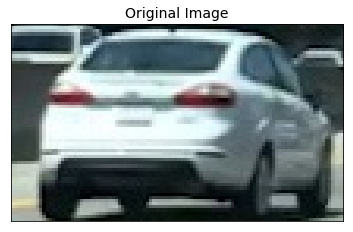

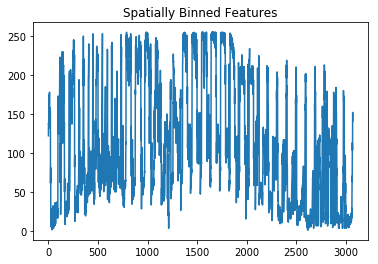

In [10]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('resources/cutout1.jpg')
show_images([image],['Original Image'])

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image,size).ravel()
    #features = img.ravel() # Remove this line!
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

## Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
Image of size:  (64, 64, 3)  and data type: float32


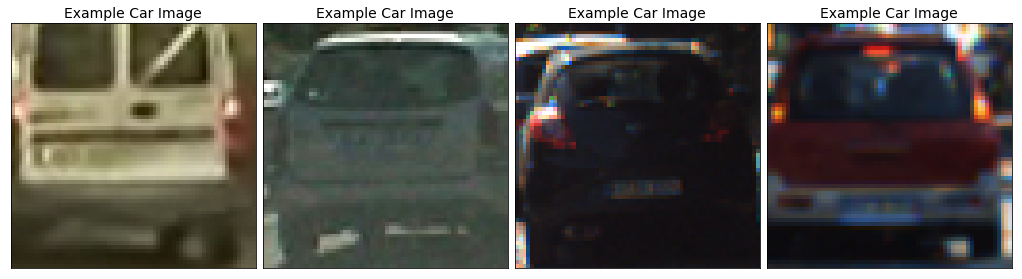

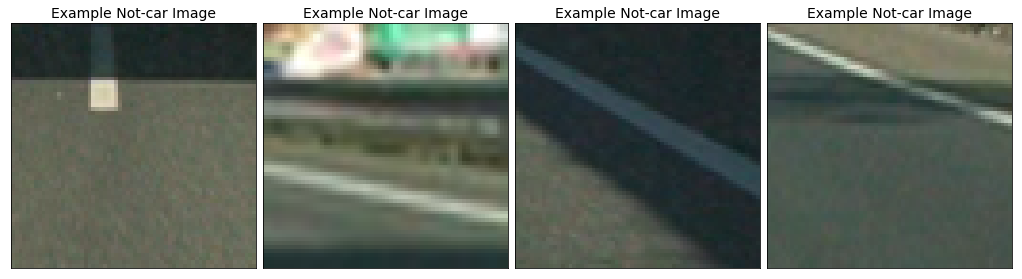

In [11]:
# images are divided up into vehicles and non-vehicles

# carimages = glob.glob('resources/vehicles_smallset/*/*.jpeg')
# notcarimages = glob.glob('resources/non-vehicles_smallset/*/*.jpeg')

carimages = glob.glob('resources/vehicles/*/*.png')
notcarimages = glob.glob('resources/non-vehicles/*/*.png')

cars = []
notcars = []

for image in carimages:
    cars.append(image)

for image in notcarimages:
    notcars.append(image)
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('Image of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# # Just for fun choose random car / not-car indices and plot example images   
# car_ind = np.random.randint(0, len(cars))
# notcar_ind = np.random.randint(0, len(notcars))

# # np.random.randint(2, size=10)

# # Read in car / not-car images
# car_image = mpimg.imread(cars[car_ind])
# notcar_image = mpimg.imread(notcars[notcar_ind])

# show_images([car_image,notcar_image],['Example Car Image','Example Not-car Image'],cols = 2)

showlen = 4
car_image = []
notcar_image = []

for i in range(showlen):
    car_image.append(mpimg.imread(cars[np.random.randint(len(cars))]))
    notcar_image.append(mpimg.imread(notcars[np.random.randint(len(notcars))]))  
    
show_images(car_image,showlen * ['Example Car Image'],cols = showlen)    
show_images(notcar_image,showlen * ['Example Not-car Image'],cols = showlen)  

## HOG Feature

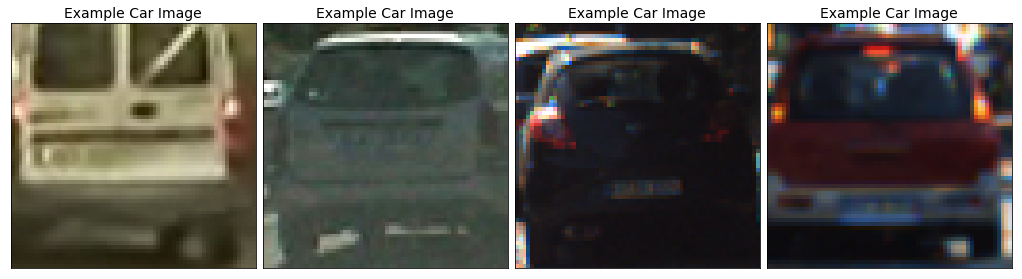

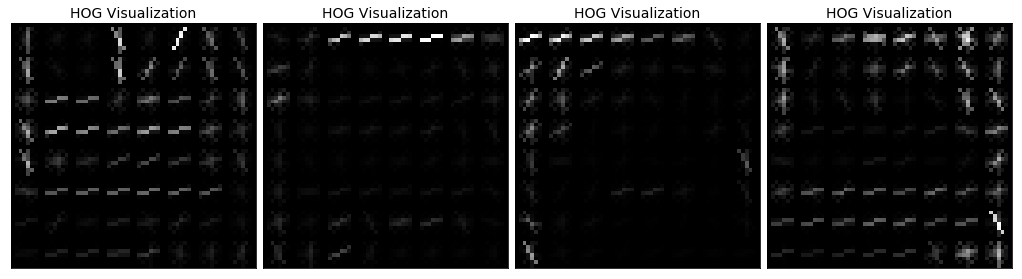

In [12]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
vis=True
feature_vec=False

def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=vis, feature_vec=feature_vec):
     
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False,block_norm = 'L1')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec,block_norm = 'L1')
        return features

gray_car_image = list(map(convert_to_gray,car_image))

res = list(map(get_hog_features,gray_car_image))

car_features = [s[0] for s in res]
car_hog_image = [s[1] for s in res]

show_images(car_image,showlen * ['Example Car Image'],cols = showlen) 
show_images(car_hog_image,showlen * ['HOG Visualization'],cols = showlen) 

## Combine and Normalize Features

In order to train a classifier in any machine learning application, data should be normalized. Python's sklearn package provides `StandardScaler()` method to accomplish this task.

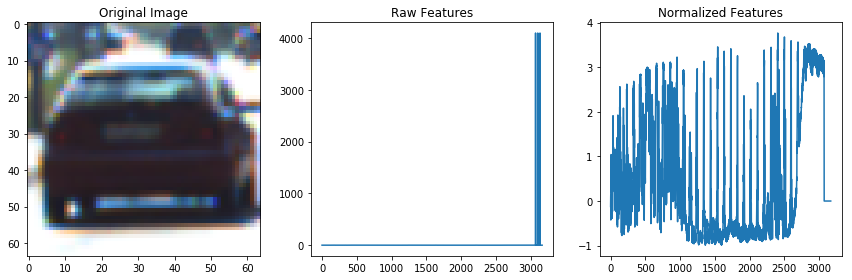

In [13]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
        else:feature_image = np.copy(image)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image,size=spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(feature_image,nbins=hist_bins,bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features,hist_features)))
    # Return list of feature vectors
    return features

car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Color Classify

In [14]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
30.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9029
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.0 Seconds to predict 10 labels with SVC


## HOG Classify

In [15]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

42.04 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
6.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9398
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
0.0 Seconds to predict 10 labels with SVC


## HOG Parameter Search

In [16]:
# from skopt import gp_minimize

# # space  = [["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"], #color space
# #           (6, 16),                  # orient
# #           (4, 16),                  # pix_per_cell
# #           (1, 4),                   # cell_per_block
# #           [0, 1, 2, "ALL"]]         # hog channel    

# space  = [["YCrCb"], #color space
#           (9, 16),                  # orient
#           (4, 16),                  # pix_per_cell
#           (1, 2),                   # cell_per_block
#           ["ALL"]]         # hog channel  

# # space  = [["YCrCb"], #color space
# #           [12],                  # orient
# #           (4,12),                  # pix_per_cell
# #           [ 2],                   # cell_per_block
# #           ["ALL"]]         # hog channel  

# i = 0
# sample_size = 1000#len(cars)
# def obj(params):
#     global i
#     colorspace,orient, pix_per_cell, cell_per_block,hog_channel= params
#     car_features = extract_features(cars[0:sample_size], cspace=colorspace, orient=orient, 
#                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel)
#     notcar_features = extract_features(notcars[0:sample_size], cspace=colorspace, orient=orient, 
#                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel)
#     y = np.hstack((np.ones(len(cars[0:sample_size])), np.zeros(len(notcars[0:sample_size]))))
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
#     # Fit a per-column scaler
#     X_scaler = StandardScaler().fit(X)
#     # Apply the scaler to X
#     scaled_X = X_scaler.transform(X)
#     X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)
#     svc = LinearSVC()
#     svc.fit(X_train, y_train)
#     test_acc = svc.score(X_test, y_test)
#     print(i, params, test_acc)
#     i+=1
#     return 1-test_acc
    
# res = gp_minimize(obj, space, n_calls=10, random_state=22)
# print("Best score=%.4f" % res.fun)
# print(res.x)

## Color and Hog Feature Combined Classify

### Feature Function

In [17]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,block_norm = 'L1')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,block_norm = 'L1')
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Feature Extract

In [18]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Generated:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

Generated: 12 orientations 8 pixels per cell and 2 cells per block


### Train Classifier

In [19]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

print('Train classifier ...')
# Use a linear SVC 
svc = LinearSVC()
# svc = svm.SVC(C=1.0, kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = svm.SVC()
# parameters = {'C':[1, 10]}
# svc = LinearSVC()
# clf = grid_search.GridSearchCV(svc, parameters)
# t=time.time()
# clf.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# print(clf.get_params)

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
Train classifier ...
4.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


### Save Train Classifier Parameters

In [20]:
# Save the parameters
save_file = "svc_pickle.p"

dist_pickle = {}
dist_pickle["color_space"] = color_space
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
pickle.dump( dist_pickle, open(save_file , "wb" ) )

### Restore Train Classifier Parameters

In [21]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

color_space = dist_pickle["color_space"]
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"] 
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"] 

## Car position location

### Sliding Window Implementation

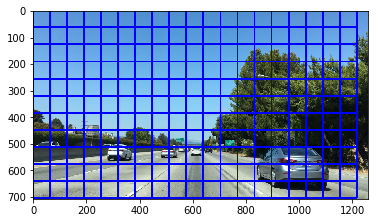

In [22]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('resources/bbox-example-image.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)    
plt.imshow(window_img)

## Search and Classify

In [23]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

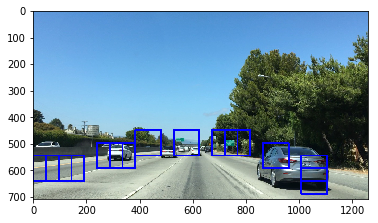

In [24]:
image = mpimg.imread('resources/bbox-example-image.jpg')

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

y_start_stop = [400, 700] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## Hog Sub-sampling Window Search

Using a 64 x 64 base window. If we define cells per pixel as 8 x 8, then a scale of 1 would retain a window that's 8 x 8 cells (8 cells to cover 64 pixels in either direction). An overlap of each window can be defined in terms of the cell distance, using cells_per_step. This means that a cells_per_step = 2 would result in a search window overlap of 75% (2 is 25% of 8, so we move 25% each time, leaving 75% overlap with the previous window). 

Any value of scale that is larger or smaller than one will scale the base image accordingly, resulting in corresponding change in the number of cells per window. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [25]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_area_check(img, ystart, ystop,scale,cells_per_step = 2):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
#     plt.figure(figsize=(14, 14))
#     plt.imshow(cv2.cvtColor(ctrans_tosearch, cv2.COLOR_YCrCb2RGB))
        
    ch1 = ctrans_tosearch[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
#     print(nxblocks)
#     print(nyblocks)
    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Define an empty list to take bbox coords
    bbox_list = []
#     print(nblocks_per_window)
    
#     print(nxsteps)
#     print(nysteps)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
           
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell          

            if True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return ctrans_tosearch,draw_img,bbox_list

### find cars of area check

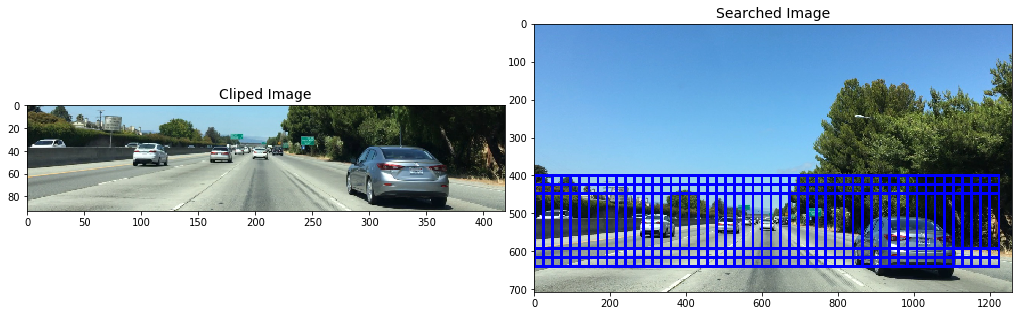

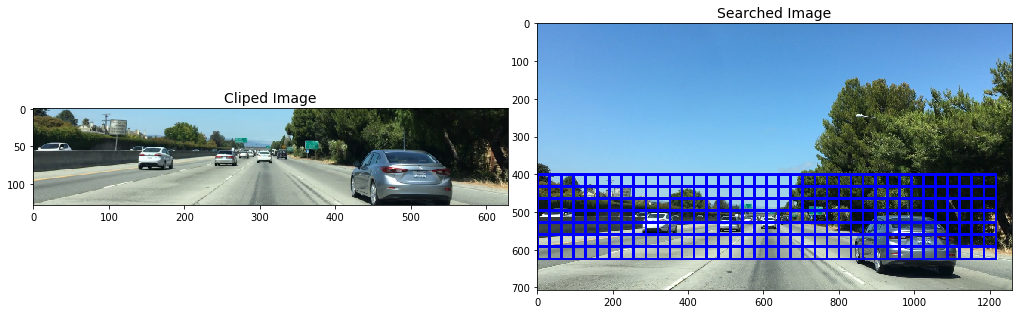

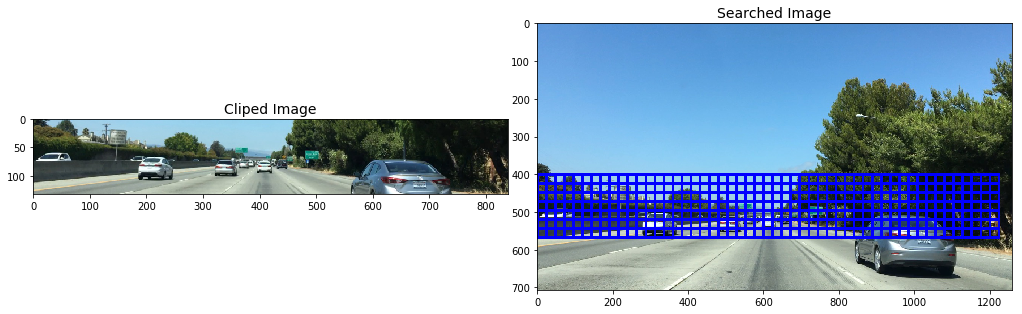

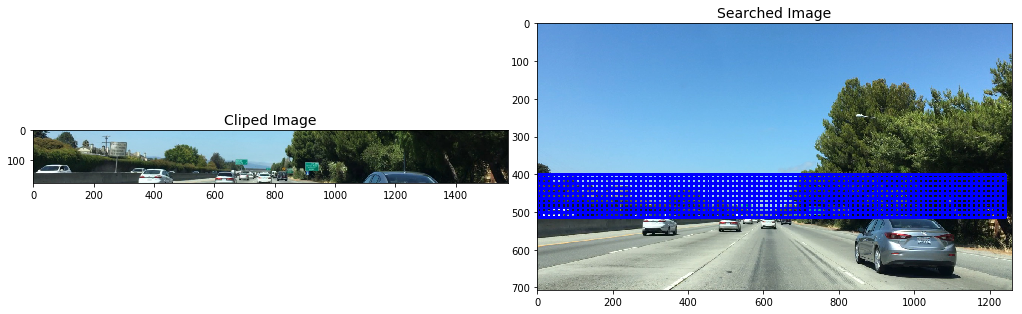

In [26]:
img = mpimg.imread('resources/bbox-example-image.jpg')

ystart = 400
scale = 3
ystop = 680
cells_per_step = 1

clip_img, out_img, box_list = find_cars_area_check(img, ystart, ystop, scale,cells_per_step)

show_images([clip_img,out_img],['Cliped Image','Searched Image'],cols = 2,ticksshow = True)

ystart = 400
scale = 2
ystop = 656
cells_per_step = 2

clip_img, out_img, box_list = find_cars_area_check(img, ystart, ystop, scale,cells_per_step)

show_images([clip_img,out_img],['Cliped Image','Searched Image'],cols = 2,ticksshow = True)

ystart = 400
scale = 1.5
ystop = 600
cells_per_step = 2

clip_img, out_img, box_list = find_cars_area_check(img, ystart, ystop, scale,cells_per_step)

show_images([clip_img,out_img],['Cliped Image','Searched Image'],cols = 2,ticksshow = True)

ystart = 400
scale = 0.8
ystop = 540
cells_per_step = 2

clip_img, out_img, box_list = find_cars_area_check(img, ystart, ystop, scale,cells_per_step)

show_images([clip_img,out_img],['Cliped Image','Searched Image'],cols = 2,ticksshow = True)

## Find cars

In [27]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec,block_norm = 'L1')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec,block_norm = 'L1')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, \
              pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step,spatial_feat=False, hist_feat=False, hog_feat=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
#     plt.figure(figsize=(14, 14))
#     plt.imshow(cv2.cvtColor(ctrans_tosearch, cv2.COLOR_YCrCb2RGB))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Define an empty list to take bbox coords
    bbox_list = []
    
    
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            if spatial_feat or hist_feat:
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            if hog_feat and spatial_feat != True and hist_feat != True:
                test_features = X_scaler.transform(((hog_features)).reshape(1, -1))   
            
            if spatial_feat and hist_feat and hog_feat:
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            
            test_prediction = svc.predict(test_features)
            
    
            if test_prediction == 1:
#             if True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    
                
    return draw_img,bbox_list

## Heat map Filtering

To make a heat-map, heat-map will add "heat" (+=1) for all pixels within windows where a positive detection is reported by classifier.

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heatmap_filter(img,box_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return heatmap,draw_img

def find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler, orient,\
                               pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step,deg_show = True):
    
    out_img,box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler,\
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step)
    
    heatmap,draw_img = heatmap_filter(img,box_list) 
    
    result = draw_boxes(img, box_list)
    
    if deg_show:
        fig = plt.figure(figsize=(18, 18))
        plt.subplot(131)
        plt.imshow(result)
        plt.title('boxed list Car Positions')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(133)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    
#     return result,heatmap,draw_img

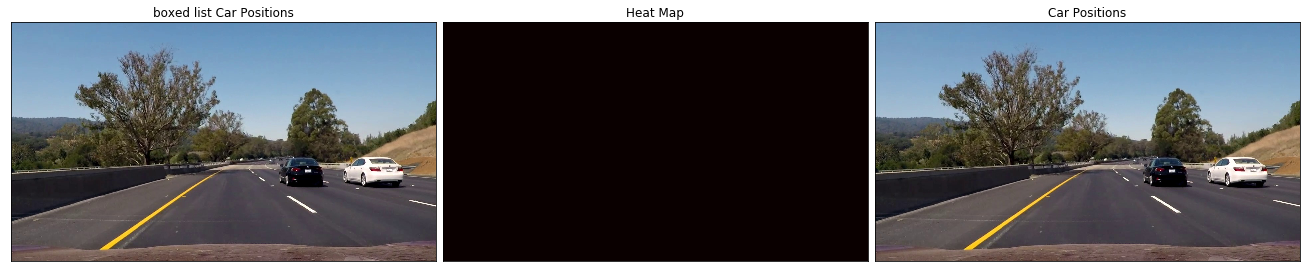

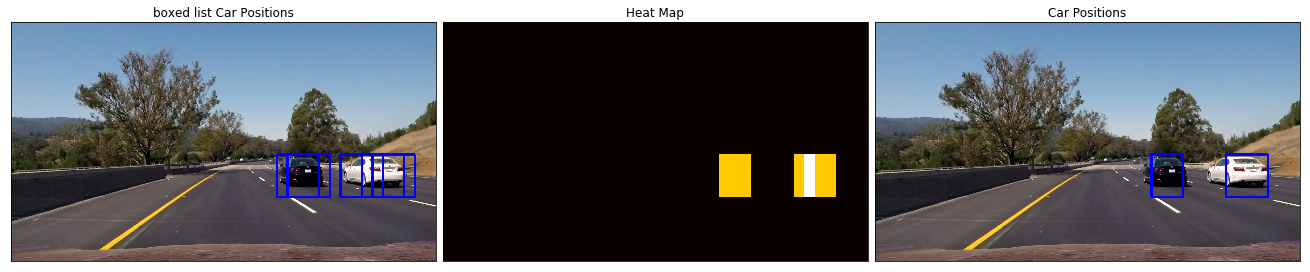

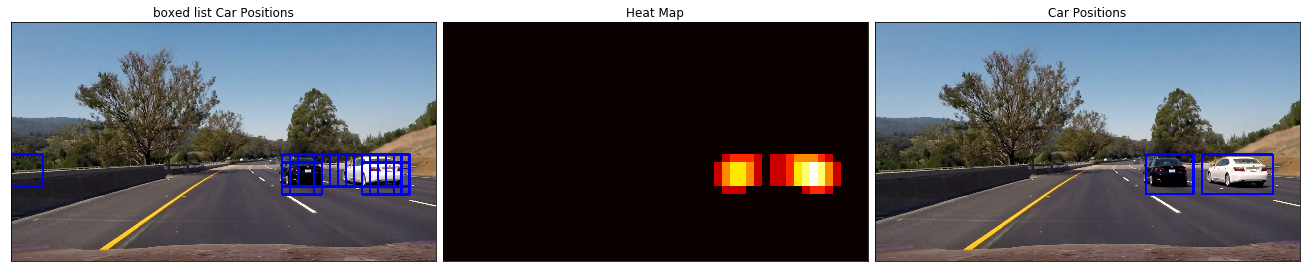

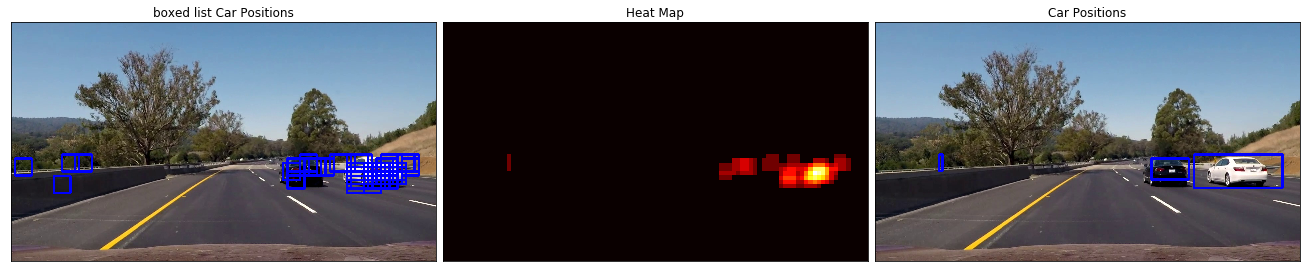

In [30]:
img = mpimg.imread('test_images/test5.jpg')
# img = mpimg.imread('test_images/bbox-example-image.jpg')
# img = img.astype(np.float32)/255


ystart = 400
scale = 3
ystop = 680
cells_per_step = 1

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler,\
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step)

ystart = 400
scale = 2
ystop = 656
cells_per_step = 2

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler,\
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step)

ystart = 400
scale = 1.5
ystop = 600
cells_per_step = 2

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler,\
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step)

ystart = 400
scale = 0.8
ystop = 540
cells_per_step = 2

find_car_heatmap(img, ystart, ystop, scale, svc, X_scaler,\
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step)

## Define Vechile dectect Class

In [31]:
from collections import deque

class Vechiledectect():
    def __init__(self,maxlen=15):
        
        self.ystart = 400
        self.ystop = 656
        self.scale = 1.5
        self.cells_per_step = 2
        
        dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
        self.svc = dist_pickle["svc"]
        self.X_scaler = dist_pickle["scaler"]
        self.orient = dist_pickle["orient"]
        self.pix_per_cell = dist_pickle["pix_per_cell"]
        self.cell_per_block = dist_pickle["cell_per_block"]
        self.spatial_size = dist_pickle["spatial_size"]
        self.hist_bins = dist_pickle["hist_bins"]
        
        self.spatial_feat = dist_pickle["spatial_feat"]
        self.hist_feat = dist_pickle["hist_feat"]
        self.hog_feat = dist_pickle["hog_feat"] 
        
        self.heatmaps = deque(maxlen = maxlen)
    
    def vechile_find(self,image,debugcombined = True,framenumber = None):
        #multi scale search
        search_parameter = [[400,720,3.0,1],\
                            [400,656,2.0,1],\
                            [400,600,1.5,2],\
                            [400,550,1.0,2],\
                            [400,510,0.8,2]]

        box_lists = []
        for i in range(len(search_parameter)):
            [self.ystart, self.ystop, self.scale, self.cells_per_step] = search_parameter[i]
            
            #rescale recording to image size
            self.ystart = int(image.shape[0]*(self.ystart/720))
            self.ystop = int(image.shape[0]*(self.ystop/720))
            
            out_img,box_list = find_cars(image, self.ystart, self.ystop, self.scale, self.svc, self.X_scaler, self.orient,\
                             self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins,self.cells_per_step,\
                                        self.spatial_feat,self.hist_feat,self.hog_feat)

            box_lists += box_list

        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat,box_lists)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,len(search_parameter)+1-1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        self.heatmaps.append(heatmap)

        heatmap = np.mean(self.heatmaps,axis=0)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        if debugcombined == True:
            # Calculate the size of screens
            result_screen_w = image.shape[1]
            result_screen_h = image.shape[0]
            debug_screen_w = np.int(result_screen_w/2)
            debug_screen_h = np.int(result_screen_h/2)
            screen_w = result_screen_w + debug_screen_w
            screen_h = result_screen_h

            # Assign result image to the screen
            #show screen
            screen = np.zeros((screen_h,screen_w,3),dtype=np.uint8)

#             if framenumber != None:
#                 cv2.putText(unwarp_images,'frame index:{:}'.format(framenumber),(10,270),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)

            screen[0:result_screen_h,0:result_screen_w,:] = draw_img

            result = draw_boxes(image, box_lists)
            # Assign debug image to the screen
            screen[0:debug_screen_h,result_screen_w:,:] = cv2.resize(result,(debug_screen_w,debug_screen_h))

            if np.max(heatmap)> 0:
                debug_img_1 = np.dstack((heatmap,heatmap,heatmap))*int(255/np.max(heatmap))
                screen[debug_screen_h : debug_screen_h*2,result_screen_w:,:] =cv2.resize(debug_img_1,(debug_screen_w,debug_screen_h))

            return screen
        else:
            return draw_img

## Show Test Results

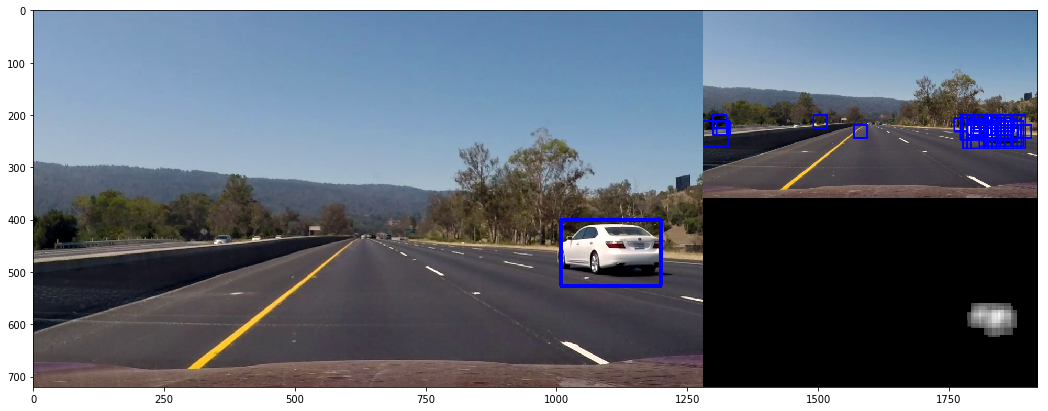

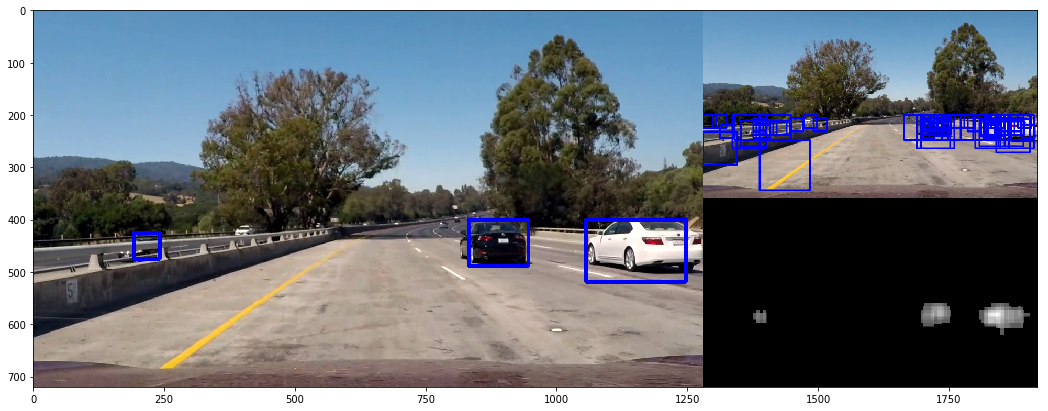

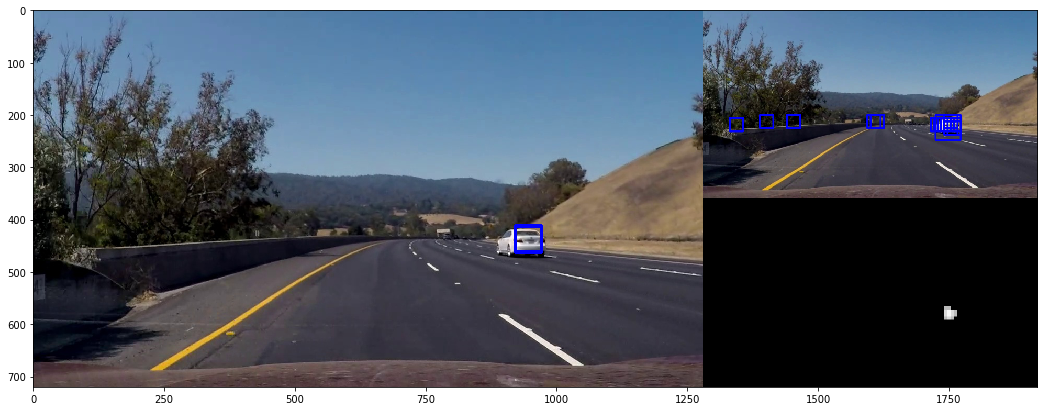

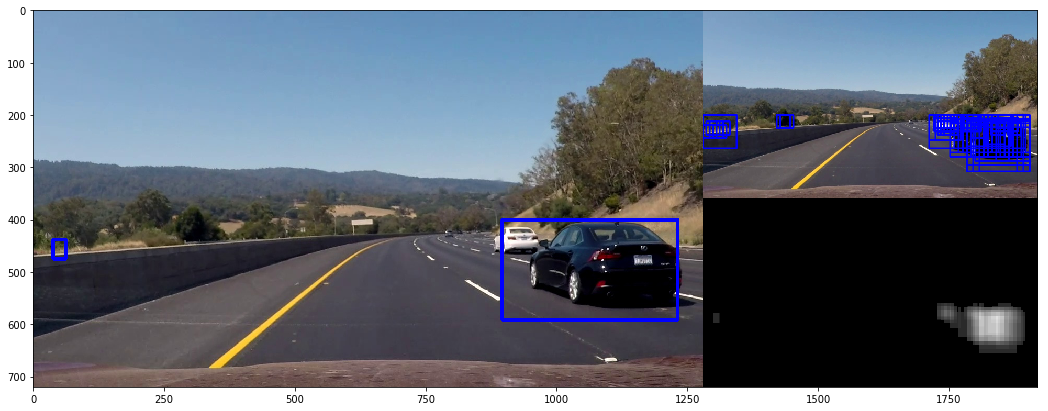

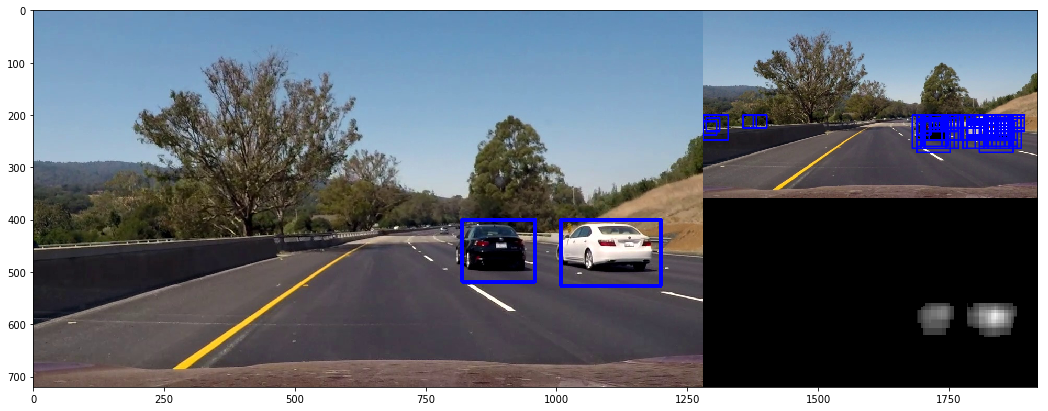

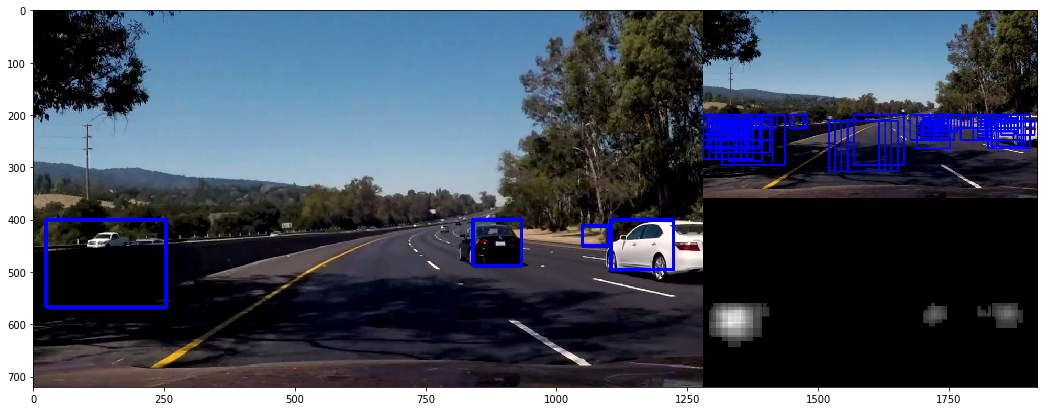

In [32]:
test_images = [plt.imread(path) for path in glob.glob('test_images/test*.jpg')]

for i, image in enumerate(test_images):
    L = Vechiledectect()

    res = L.vechile_find(image)

    fig = plt.figure(figsize=(18, 18))
    plt.imshow(res)

## Test on Videos

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
project_source = "test_videos/project_video.mp4"
project_output = "test_videos_output/project_video_output.mp4"


## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
L = Vechiledectect()

clip1 = VideoFileClip(project_source)
line_clip = clip1.fl_image(L.vechile_find) #NOTE: this function expects color images!!
%time line_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [17:39<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 17min 40s


In [35]:
HTML("""
<video width="960" height="450" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [36]:
line_clip.resize(height=240).speedx(5).to_gif('resources/project.gif')


[MoviePy] Building file resources/project.gif with imageio


100%|█████████▉| 252/253 [03:49<00:00,  1.11it/s]


## Results

![](resources/project.gif)